In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import string

import nltk
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from wordcloud import WordCloud
from tqdm.auto import tqdm
import matplotlib.style as style
style.use('fivethirtyeight')
from sklearn.metrics import plot_roc_curve
from numpy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import openpyxl


[nltk_data] Downloading package punkt to /Users/berin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [71]:
data = pd.read_csv("titledata.csv")


In [72]:
data.head()

,title,view_count
0,Why Germany is hooked on Russian gas,1277339
1,The hidden history of “Hand Talk”,444674
2,"The world's biggest wave, explained",894896
3,Who made these circles in the Sahara?,3412022
4,Why Frank Lloyd Wright’s windows look like this,853931


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       500 non-null    object
 1   view_count  500 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.9+ KB


In [74]:
(data.isnull().sum() / len(data)) * 100

title         0.0
view_count    0.0
dtype: float64

In [75]:
def remove_line_breaks(text):
    text = text.replace('\r', ' ').replace('\n', ' ')
    return text

#remove punctuation
def remove_punctuation(text):
    re_replacements = re.compile("__[A-Z]+__")  # such as __NAME__, __LINK__
    re_punctuation = re.compile("[%s]" % re.escape(string.punctuation))
    '''Escape all the characters in pattern except ASCII letters and numbers'''
    tokens = word_tokenize(text)
    tokens_zero_punctuation = []
    for token in tokens:
        if not re_replacements.match(token):
            token = re_punctuation.sub(" ", token)
        tokens_zero_punctuation.append(token)
    return ' '.join(tokens_zero_punctuation)

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def lowercase(text):
    text_low = [token.lower() for token in word_tokenize(text)]
    return ' '.join(text_low)

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    text = " ".join([word for word in word_tokens if word not in stop])
    return text

#remobe one character words
def remove_one_character_words(text):
    '''Remove words from dataset that contain only 1 character'''
    text_high_use = [token for token in word_tokenize(text) if len(token)>1]      
    return ' '.join(text_high_use)   
    
#%%
# Stemming with 'Snowball stemmer" package
def stem(text):
    stemmer = nltk.stem.snowball.SnowballStemmer('english')
    text_stemmed = [stemmer.stem(token) for token in word_tokenize(text)]        
    return ' '.join(text_stemmed)

def lemma(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    word_tokens = nltk.word_tokenize(text)
    text_lemma = " ".join([wordnet_lemmatizer.lemmatize(word) for word in word_tokens])       
    return ' '.join(text_lemma)


#break sentences to individual word list
def sentence_word(text):
    word_tokens = nltk.word_tokenize(text)
    return word_tokens
#break paragraphs to sentence token 
def paragraph_sentence(text):
    sent_token = nltk.sent_tokenize(text)
    return sent_token    


def tokenize(text):
    """Return a list of words in a text."""
    return re.findall(r'\w+', text)

def remove_numbers(text):
    no_nums = re.sub(r'\d+', '', text)
    return ''.join(no_nums)



def clean_text(text):
    _steps = [
    remove_line_breaks,
    remove_one_character_words,
    remove_special_characters,
    lowercase,
    remove_punctuation,
    remove_stopwords,
    stem,
    remove_numbers
]
    for step in _steps:
        text=step(text)
    return text   
#%%

In [76]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/berin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [77]:
data['clean_title'] = pd.Series([clean_text(i) for i in tqdm(data['title'])])

  0%|          | 0/500 [00:00<?, ?it/s]

In [78]:
words = data["clean_title"].values

In [79]:
ls = []

for i in words:
    ls.append(str(i))

In [80]:
ls[:5]

['germani hook russian gas',
 'hidden histori hand talk',
 'world biggest wave explain',
 'made circl sahara',
 'frank lloyd wright window look like']

(-0.5, 1599.5, 799.5, -0.5)

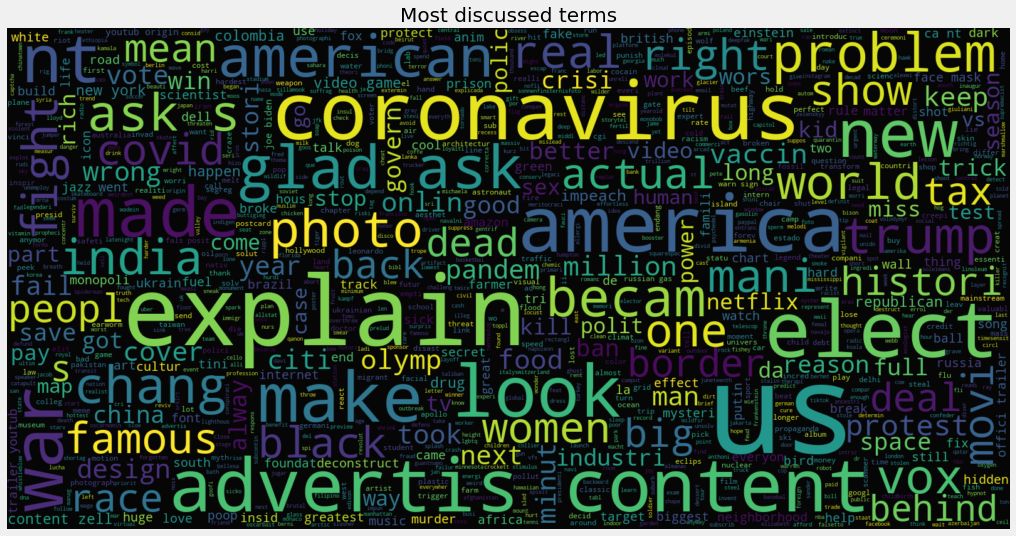

In [81]:
# The wordcloud of Cthulhu/squidy thing for HP Lovecraft
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=1000, max_font_size= 200,  width=1600, height=800)
wc.generate(" ".join(ls))
plt.title("Most discussed terms", fontsize=20)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.98, interpolation="bilinear", )
plt.axis('off')

In [82]:
most_pop = data.sort_values('view_count', ascending =False)[['title', 'view_count']].head(12)

most_pop['score1'] = most_pop['view_count']/1000

Text(0.5, 1.0, 'Most popular posts')

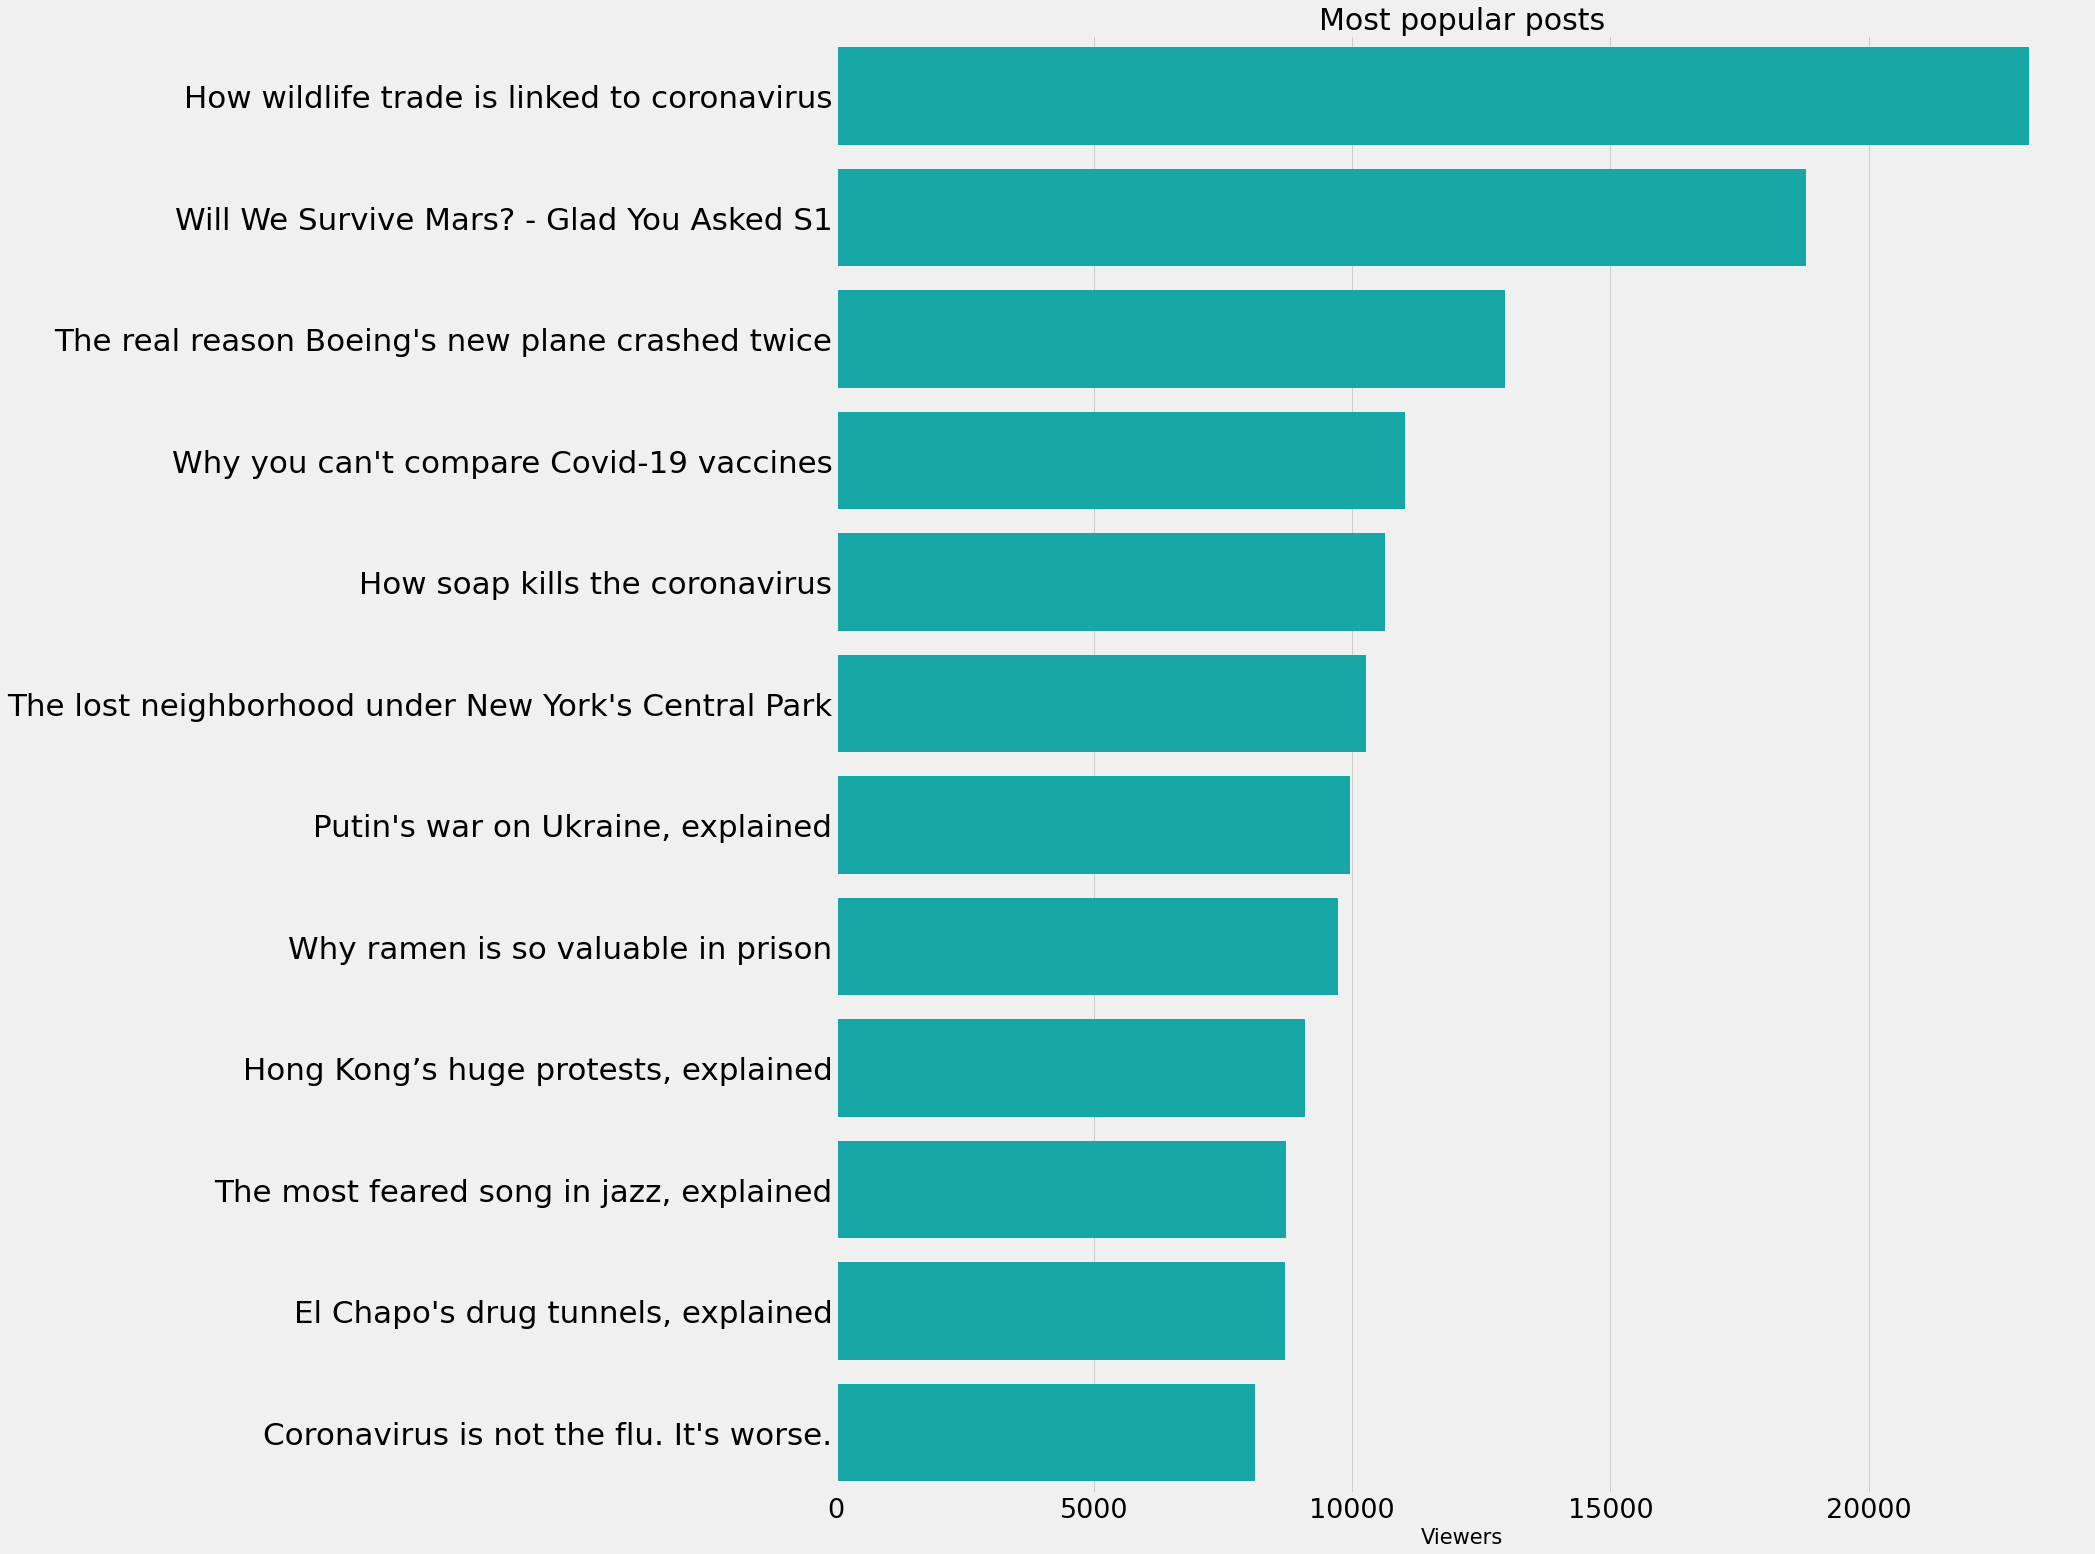

In [83]:
plt.figure(figsize = (20,25))

sns.barplot(data = most_pop, y = 'title', x = 'score1', color = 'c')
plt.xticks(fontsize=27, rotation=0)
plt.yticks(fontsize=31, rotation=0)
plt.xlabel('Viewers', fontsize = 21)
plt.ylabel('')
plt.title('Most popular posts', fontsize = 30)

In [84]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk

In [85]:
stemmer = SnowballStemmer('english')

In [86]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/berin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [87]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [88]:
data['title'].iloc[1]

'The hidden history of “Hand Talk”'

In [89]:
doc_sample = data['title'].iloc[1]
print('original document: ')

words = []

for word in doc_sample.split(' '):
    words.append(word)
    
    
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['The', 'hidden', 'history', 'of', '“Hand', 'Talk”']


 tokenized and lemmatized document: 
['hide', 'histori', 'hand', 'talk']


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        500 non-null    object
 1   view_count   500 non-null    int64 
 2   clean_title  500 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.8+ KB


In [91]:
data['clean_title'] = data['clean_title'].astype(str)

In [97]:
words = []

for i in data['clean_title']:
        words.append(i.split(' '))

In [98]:
dictionary = gensim.corpora.Dictionary(words)
print (len(dictionary) )
count = 0
print(dictionary)

for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 1200:
        break


1182
Dictionary<1182 unique tokens: ['gas', 'germani', 'hook', 'russian', 'hand']...>
0 gas
1 germani
2 hook
3 russian
4 hand
5 hidden
6 histori
7 talk
8 biggest
9 explain
10 wave
11 world
12 circl
13 made
14 sahara
15 frank
16 like
17 lloyd
18 look
19 window
20 wright
21 becam
22 meme
23 new
24 propaganda
25 putin
26 ban
27 give
28 russia
29 us
30 weapon
31 intern
32 mean
33 space
34 station
35 war
36 art
37 save
38 ukrainian
39 chair
40 everyon
41 china
42 fruit
43 punish
44 taiwan
45 use
46 good
47 hous
48 idea
49 peopl
50 steel
51 thought
52 stalin
53 starv
54 ukrain
55 insid
56 one
57 spiderman
58 suit
59 escap
60 rail
61 done
62 face
63 mask
64 chang
65 nofli
66 would
67 zone
68 moment
69 volodymyr
70 zelenskyy
71 american
72 conserv
73 turn
74 vaccin
75 anymor
76 care
77 child
78 univers
79 build
80 defens
81 gentrif
82 danger
83 olymp
84 reason
85 sled
86 border
87 italyswitzerland
88 melt
89 event
90 monobob
91 women
92 race
93 secret
94 short
95 skate
96 speed
97 track
98 win

In [99]:
input = "Russian gives to Merkel gass but no Fuck and people wants no warr to rid away from Covid-19 and we'll see how it goes coronavirus"


print('original document: ')

words = []

for word in input.split(' '):
    words.append(word)
    
    
    
print(words)
print('\n\ntokenized and lemmatized document: ')

inputWordsEdited = preprocess(input)

print(inputWordsEdited)


print(dictionary.doc2bow(inputWordsEdited))

original document: 
['Russian', 'gives', 'to', 'Merkel', 'gass', 'but', 'no', 'Fuck', 'and', 'people', 'wants', 'no', 'warr', 'to', 'rid', 'away', 'from', 'Covid-19', 'and', "we'll", 'see', 'how', 'it', 'goes', 'coronavirus']


tokenized and lemmatized document: 
['russian', 'give', 'merkel', 'gas', 'fuck', 'peopl', 'want', 'warr', 'away', 'covid', 'go', 'coronavirus']
[(0, 1), (3, 1), (27, 1), (49, 1), (174, 1), (323, 1), (641, 1), (795, 1), (1086, 1)]


In [100]:
dictionary.token2id.items()

dict_items([('gas', 0), ('germani', 1), ('hook', 2), ('russian', 3), ('hand', 4), ('hidden', 5), ('histori', 6), ('talk', 7), ('biggest', 8), ('explain', 9), ('wave', 10), ('world', 11), ('circl', 12), ('made', 13), ('sahara', 14), ('frank', 15), ('like', 16), ('lloyd', 17), ('look', 18), ('window', 19), ('wright', 20), ('becam', 21), ('meme', 22), ('new', 23), ('propaganda', 24), ('putin', 25), ('ban', 26), ('give', 27), ('russia', 28), ('us', 29), ('weapon', 30), ('intern', 31), ('mean', 32), ('space', 33), ('station', 34), ('war', 35), ('art', 36), ('save', 37), ('ukrainian', 38), ('chair', 39), ('everyon', 40), ('china', 41), ('fruit', 42), ('punish', 43), ('taiwan', 44), ('use', 45), ('good', 46), ('hous', 47), ('idea', 48), ('peopl', 49), ('steel', 50), ('thought', 51), ('stalin', 52), ('starv', 53), ('ukrain', 54), ('insid', 55), ('one', 56), ('spiderman', 57), ('suit', 58), ('escap', 59), ('rail', 60), ('done', 61), ('face', 62), ('mask', 63), ('chang', 64), ('nofli', 65), ('wo

In [53]:
# Filter out tokens in the dictionary by their frequency.

dictionary.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

In [55]:
bow_corpus = [dictionary.doc2bow(doc) for doc in words]
bow_corpus

[[],
 [],
 [(0, 1)],
 [(1, 1)],
 [(2, 1), (3, 1)],
 [(4, 1)],
 [(5, 1)],
 [(6, 1)],
 [(6, 1)],
 [],
 [],
 [],
 [],
 [],
 [(0, 1)],
 [],
 [(6, 1)],
 [(0, 1)],
 [(0, 1), (6, 1)],
 [],
 [(5, 1)],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(7, 1), (8, 1)],
 [(3, 1)],
 [(7, 1), (8, 1)],
 [(5, 1)],
 [],
 [],
 [(7, 1), (8, 1)],
 [(9, 1)],
 [(2, 1), (3, 1)],
 [(7, 1), (8, 1)],
 [],
 [(5, 1)],
 [(10, 1)],
 [],
 [],
 [(2, 1)],
 [(5, 1)],
 [],
 [(7, 1), (8, 1)],
 [],
 [(2, 1)],
 [(0, 1)],
 [],
 [(7, 1), (8, 1)],
 [(3, 1), (11, 1)],
 [(9, 1)],
 [(5, 1)],
 [(4, 1)],
 [],
 [(7, 1), (8, 1)],
 [],
 [],
 [],
 [(0, 1)],
 [],
 [],
 [(1, 1)],
 [(5, 1), (10, 1)],
 [(12, 1)],
 [(4, 1)],
 [],
 [(1, 1), (13, 1)],
 [(13, 1)],
 [],
 [],
 [(5, 1)],
 [(1, 1), (5, 1)],
 [(7, 1), (8, 1), (11, 1)],
 [],
 [(5, 1)],
 [(11, 1)],
 [(3, 1), (11, 1)],
 [],
 [(5, 1)],
 [],
 [],
 [(5, 1), (11, 1)],
 [(10, 1)],
 [],
 [(7, 1), (8, 1)],
 [],
 [(14, 1)],
 [],
 [(10, 1)],
 [],
 [(6, 1)],
 [(3, 1)],
 [],
 [],
 [(4, 1)],


In [56]:
bow_doc_18 = bow_corpus[90]

for i in range(len(bow_doc_18)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_18[i][0], 
                                               dictionary[bow_doc_18[i][0]], 
bow_doc_18[i][0]))

Word 7 ("advertis") appears 7 time.
Word 8 ("content") appears 8 time.


In [57]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[]


In [58]:
lda_model = gensim.models.LdaMulticore(bow_corpus,
                                       num_topics=10,
                                       id2word=dictionary,
                                       passes=2,
                                       workers=2)

In [ ]:
#scikit-learn kütüphanelerine bakalım. 